Import reqired libraries

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


We read the training and validation data and set the batch size

In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 8

## Explore the dataset

In [4]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


Explore the data distribution for the training split

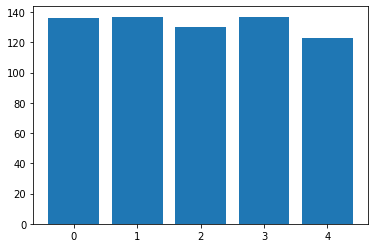

In [5]:
training_dict = dict()
for row in train_doc:
    key = row.strip().split(';')[-1]
    if key not in training_dict:
        training_dict[key] = 0
    training_dict[key] = training_dict[key] + 1
    
x = sorted(list(training_dict.keys()))
y = [training_dict[k] for k in x]
plt.bar(x,y)
plt.show()

The above plot shows that the data is not skewed in favour of one class and is well-balanced.<br>
Let's repeat the same for validation data as well.

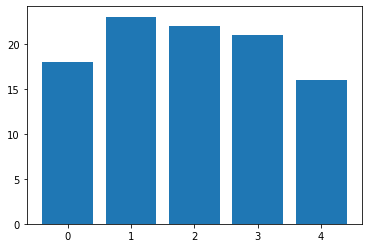

In [6]:
val_dict = dict()
for row in val_doc:
    key = row.strip().split(';')[-1]
    if key not in val_dict:
        val_dict[key] = 0
    val_dict[key] = val_dict[key] + 1
    
x = sorted(list(val_dict.keys()))
y = [val_dict[k] for k in x]
plt.bar(x,y)
plt.show()

The validation split is slightly less balanced than the training one. However, the skew still isn't very large and hence accuracy as a metric will not lead to poor result. For confidence, we will use AUC score as well in our evaluation.

## Generator

For providing input to our model, we need to ensure the input size is constant. Our training data comprises of frames with two sizes: (120,160) and (360,360).
We'll pad the (120,160) using edge values to a size of (160,160) and scale the (360,360) image down to (160,160).

Also to augment the training dataset, we'll skip 2 frames after each frame, giving us 10 frames and then repeat the beginning and ending frame to get a sequence length of 15 frames per each folder. For the validation dataset, we'll skip only 1 frame instead, to get the 15 frames directly.

The idea behind this augmentation is that different sequences have the gesture being performed at different times and pace. This might help generalize for the same.

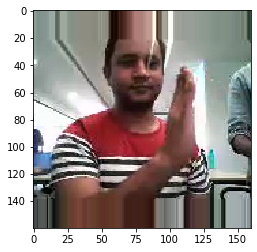

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator

folder = 'WIN_20180926_17_15_56_Pro_Right_Swipe_new'
filename = os.listdir('Project_data/train/{}'.format(folder))[0]
img = imread('Project_data/train/{}/{}'.format(folder, filename))
img = np.pad(img, pad_width=((20, 20), (0, 0), (0,0)), mode='edge')

plt.imshow(img)

We use the above transformations in the below generator. We also normalize each image to have values between (-1,1) and be centered at 0.

In [26]:
def generator(source_path, folder_list, batch_size, aug=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)// batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,15,160,160,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                if aug:
                    # For training data, take 1 frame and then skip 2 frames which will give 10 out of 30 frames.
                    img_idx = list(range(0,30,3))
                    start = np.random.randint(0,5)
                    # Now pad it at the beginning or the end, to get 15 frames.
                    img_idx = np.pad(img_idx, pad_width=(start, 5 - start), mode='edge')
                else:
                    # For validation, directly take 1 frame and skip 1 frame to get 15 frames.
                    img_idx = list(range(0,30,2))
                    
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+
                                   '/'+imgs[item]).astype(np.float32)
                    
                    if image.shape[0] == 120:
                        image = np.pad(image, pad_width=((20, 20), (0, 0), (0,0)), mode='edge')
                    else:
                        image = imresize(image, (160, 160))
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = (image[:,:,0] - 127.5)/127.5 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1] - 127.5)/127.5 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2] - 127.5)/127.5 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        remaining_start_idx = batch_size * num_batches
        if remaining_start_idx % len(folder_list) == 0:
            continue
        last_batch_size = len(folder_list[remaining_start_idx:])
        batch_data = np.zeros((last_batch_size,15,160,160,3))
        batch_labels = np.zeros((last_batch_size,5))
        for folder in range(last_batch_size): # iterate over the batch_size
            if aug:
                img_idx = list(range(0,30,3))
                start = np.random.randint(0,5)
                img_idx = np.pad(img_idx, pad_width=(start, 5 - start), mode='edge')
            else:
                img_idx = list(range(0,30,2))
            
            imgs = os.listdir(source_path+'/'+ t[folder + remaining_start_idx].split(';')[0]) # read all the images in the folder
            for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                image = imread(source_path+'/'+ t[folder + remaining_start_idx].strip().split(';')[0]+
                               '/'+imgs[item]).astype(np.float32)

                if image.shape[0] == 120:
                    image = np.pad(image, pad_width=((20, 20), (0, 0), (0,0)), mode='edge')
                else:
                    image = imresize(image, (160, 160))

                #crop the images and resize them. Note that the images are of 2 different shape 
                #and the conv3D will throw error if the inputs in a batch have different shapes

                batch_data[folder,idx,:,:,0] = (image[:,:,0] - 127.5)/127.5 #normalise and feed in the image
                batch_data[folder,idx,:,:,1] = (image[:,:,1] - 127.5)/127.5 #normalise and feed in the image
                batch_data[folder,idx,:,:,2] = (image[:,:,2] - 127.5)/127.5 #normalise and feed in the image

            batch_labels[folder, int(t[folder + remaining_start_idx].strip().split(';')[2])] = 1
        yield batch_data, batch_labels


## Model
We use the mobile net model along with its pretrained weights obtained by training on imagenet as base for our ConvLSTM model.

In [27]:
## Helper code to run training on small GPU

from keras.backend.tensorflow_backend import set_session
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [28]:
from keras.applications import mobilenet_v2

In [29]:
mobilenet_model = mobilenet_v2.MobileNetV2(input_shape=None, alpha=1.0, include_top=False, weights='imagenet', input_tensor=None, pooling=None, classes=5)

In [30]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

model1 = Sequential()

model1.add(TimeDistributed(mobilenet_model, input_shape=(15,160,160,3))) 
model1.add(TimeDistributed(MaxPooling2D(5,5)))

# flatten and put a fully connected layer
model1.add(TimeDistributed(Flatten()))
model1.add(TimeDistributed(Dropout(0.5)))
model1.add(TimeDistributed(Dense(256, activation='relu'))) # fully connected

model1.add(GRU(256, return_sequences=False))
model1.add(Dropout(0.5))
model1.add(Dense(128, activation='relu'))
# softmax layer
model1.add(Dense(5, activation='softmax'))

# model summary
model1.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_6 (TimeDist (None, 15, 5, 5, 1280)    2257984   
_________________________________________________________________
time_distributed_7 (TimeDist (None, 15, 1, 1, 1280)    0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 15, 1280)          0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 15, 1280)          0         
_________________________________________________________________
time_distributed_10 (TimeDis (None, 15, 256)           327936    
_________________________________________________________________
gru_2 (GRU)                  (None, 256)               393984    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)              

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [31]:
optimiser = optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_6 (TimeDist (None, 15, 5, 5, 1280)    2257984   
_________________________________________________________________
time_distributed_7 (TimeDist (None, 15, 1, 1, 1280)    0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 15, 1280)          0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 15, 1280)          0         
_________________________________________________________________
time_distributed_10 (TimeDis (None, 15, 256)           327936    
_________________________________________________________________
gru_2 (GRU)                  (None, 256)               393984    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)              

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [32]:
train_generator = generator(train_path, train_doc, batch_size, aug=True)
val_generator = generator(val_path, val_doc, batch_size)

In [33]:
import keras
from sklearn.metrics import roc_auc_score

class roc_callback(keras.callbacks.Callback):
    def __init__(self, val_path, val_doc, batch_size):
        self.val_path = val_path
        self.val_doc = val_doc
        self.batch_size = batch_size
        self.num_batches = len(val_doc) // batch_size
        self.auc_scores = []

    def on_epoch_end(self, epoch, logs={}):
        val_generator = generator(self.val_path, self.val_doc, self.batch_size)
        test = None
        pred = None
        for _ in range(self.num_batches):
            X_test,y_test = next(val_generator)
            y_pred = self.model.predict(X_test)
            
            pred_idx = np.argmax(y_pred, axis=1)
            y_pred = np.zeros_like(y_test)
            y_pred[range(y_pred.shape[0]), pred_idx] = 1
            
            if test is None:
                test = y_test
                pred = y_pred
            else:
                test = np.concatenate([test, y_test], axis=0)
                pred = np.concatenate([pred, y_pred], axis=0)
            
        auc_score = roc_auc_score(test, pred, average='macro', multi_class='ovr')
        self.auc_scores.append(auc_score)
        print("validation roc auc score", auc_score)


In [34]:
model_name = 'model1_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
val_auc = roc_callback(val_path, val_doc, batch_size)
callbacks_list = [val_auc, checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [35]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [36]:
print(steps_per_epoch, validation_steps)

83 13


Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [37]:
history = model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = Source path =   Project_data/val ; batch size = 8
Project_data/train ; batch size = 8
Epoch 1/30
83/83 [==============================] - 103s 1s/step - loss: 1.8279 - categorical_accuracy: 0.2021 - val_loss: 1.6703 - val_categorical_accuracy: 0.1800
Source path =  Project_data/val ; batch size = 8
validation roc auc score 0.4854758005048357

Epoch 00001: saving model to model1_init_2020-03-3021_46_33.137537/model-00001-1.82848-0.20211-1.67035-0.18000.h5
Epoch 2/30
83/83 [==============================] - 62s 753ms/step - loss: 1.5787 - categorical_accuracy: 0.2730 - val_loss: 1.7184 - val_categorical_accuracy: 0.2300
Source path =  Project_data/val ; batch size = 8
validation roc auc score 0.5111100930040775

Epoch 00002: saving model to model1_init_2020-03-3021_46_33.137537/model-00002-1.57867-0.27300-1.71837-0.23000.h5
Epoch 3/30
83/83 [==============================] - 64s 777ms/step - loss: 1.3942 - categorical_accuracy: 0.3650 - val_loss: 1.5447 - val_categorical_ac

Epoch 23/30
83/83 [==============================] - 65s 783ms/step - loss: 0.0393 - categorical_accuracy: 0.9910 - val_loss: 0.2758 - val_categorical_accuracy: 0.7400
Source path =  Project_data/val ; batch size = 8
validation roc auc score 0.8292926667926668

Epoch 00023: saving model to model1_init_2020-03-3021_46_33.137537/model-00023-0.03930-0.99095-0.27581-0.74000.h5
Epoch 24/30
83/83 [==============================] - 65s 778ms/step - loss: 0.0673 - categorical_accuracy: 0.9849 - val_loss: 0.8949 - val_categorical_accuracy: 0.7500
Source path =  Project_data/val ; batch size = 8
validation roc auc score 0.8382437584191971

Epoch 00024: saving model to model1_init_2020-03-3021_46_33.137537/model-00024-0.06736-0.98492-0.89487-0.75000.h5
Epoch 25/30
83/83 [==============================] - 66s 790ms/step - loss: 0.0353 - categorical_accuracy: 0.9925 - val_loss: 1.1047 - val_categorical_accuracy: 0.7600
Source path =  Project_data/val ; batch size = 8
validation roc auc score 0.8342

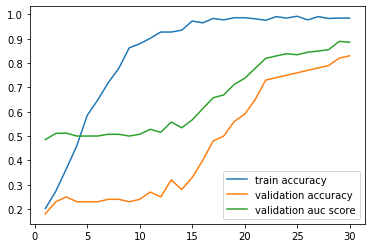

In [38]:
plt.plot(np.arange(1,31,1), history.history['categorical_accuracy'])
plt.plot(np.arange(1,31,1), history.history['val_categorical_accuracy'])
plt.plot(np.arange(1,31,1), val_auc.auc_scores)
plt.legend(['train accuracy', 'validation accuracy', 'validation auc score'])

Since the model performance was improving, we'll train for another 5 epochs.

In [39]:
history2 = model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=5, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/5
83/83 [==============================] - 73s 877ms/step - loss: 0.0536 - categorical_accuracy: 0.9849 - val_loss: 0.6943 - val_categorical_accuracy: 0.8800
Source path =  Project_data/val ; batch size = 8
validation roc auc score 0.9042316188812773

Epoch 00001: saving model to model1_init_2020-03-3021_46_33.137537/model-00001-0.05370-0.98492-0.69432-0.88000.h5
Epoch 2/5
83/83 [==============================] - 62s 752ms/step - loss: 0.0598 - categorical_accuracy: 0.9849 - val_loss: 0.2758 - val_categorical_accuracy: 0.8300
Source path =  Project_data/val ; batch size = 8
validation roc auc score 0.904020635875899

Epoch 00002: saving model to model1_init_2020-03-3021_46_33.137537/model-00002-0.05989-0.98492-0.27578-0.83000.h5
Epoch 3/5
83/83 [==============================] - 64s 777ms/step - loss: 0.0409 - categorical_accuracy: 0.9910 - val_loss: 0.2159 - val_categorical_accuracy: 0.8600
Source path =  Project_data/val ; batch size = 8
validation roc auc score 0.91268750013

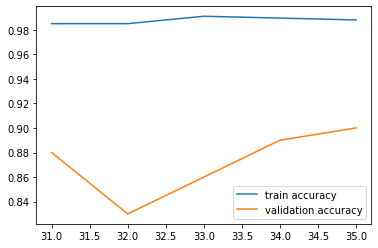

In [42]:
plt.plot(np.arange(31,36,1), history2.history['categorical_accuracy'])
plt.plot(np.arange(31,36,1), history2.history['val_categorical_accuracy'])
plt.legend(['train accuracy', 'validation accuracy', 'validation auc score'])